In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Baseline Logistic

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# -----------------------------------------------------------
# 1) Load data
# -----------------------------------------------------------
df = pd.read_csv("train.csv")

# Drop columns we don’t want

X = df.drop(columns=["PassengerId", "Cabin","Name"])

# -----------------------------------------------------------
# 2) Define target and feature matrix
# -----------------------------------------------------------
y = df["Transported"].astype(int)          # 1 / 0 is fine for logistic loss
X = X.drop(columns=["Transported"])

# -----------------------------------------------------------
# 3) Identify feature types
# -----------------------------------------------------------
categorical_cols = [
    # high-cardinality or low, all are handled the same way
    'HomePlanet', 'CryoSleep', 'Destination', 'VIP']
numeric_cols = [
    'Age', 'RoomService', 'FoodCourt',
    'ShoppingMall', 'Spa', 'VRDeck'
]

# -----------------------------------------------------------
# 4) Pre-processing pipelines
# -----------------------------------------------------------
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, categorical_cols),
        ("num", num_pipe, numeric_cols)
    ]
)

# -----------------------------------------------------------
# 5) Full modelling pipeline
# -----------------------------------------------------------
model = Pipeline(steps=[
    ("prep", preprocess),
    ("logreg", LogisticRegression(
        max_iter=1000,           # raise if convergence warnings
        penalty="l2",            # default, but explicit
        solver="lbfgs",
        class_weight="balanced"  # optional: tackle class imbalance
    ))
])

# -----------------------------------------------------------
# 6) Train / evaluate
# -----------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)
print("Validation accuracy:", model.score(X_val, y_val))

# Cross-validated ROC-AUC as an extra sanity check
cv_auc = cross_val_score(
    model, X, y, cv=5, scoring="roc_auc"
).mean()
print("5-fold ROC-AUC:", cv_auc)


Validation accuracy: 0.7872340425531915
5-fold ROC-AUC: 0.8702656860010627


In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# -----------------------------------------------------------
# 1) Load data
# -----------------------------------------------------------
df = pd.read_csv("train.csv")

# Drop columns we don’t want
df['PassengerGroup'] = df['PassengerId'].astype(str).str[0:4]
df['Cabin'].fillna("None/None/None", inplace=True)
df[["deck", "deck_num", "side"]] = df["Cabin"].str.split("/", n=2, expand=True)
df = df.drop(columns=["PassengerId", "Cabin",'Name'])

# -----------------------------------------------------------
# 2) Define target and feature matrix
# -----------------------------------------------------------
y = df["Transported"].astype(int)          # 1 / 0 is fine for logistic loss
X = df.drop(columns=["Transported"])

# -----------------------------------------------------------
# 3) Identify feature types
# -----------------------------------------------------------
categorical_cols = [
    # high-cardinality or low, all are handled the same way
    'HomePlanet', 'CryoSleep', 'Destination', 'VIP',
    'PassengerGroup', 'deck', 'deck_num', 'side'
]

numeric_cols = [
    'Age', 'RoomService', 'FoodCourt',
    'ShoppingMall', 'Spa', 'VRDeck'
]

# -----------------------------------------------------------
# 4) Pre-processing pipelines
# -----------------------------------------------------------
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, categorical_cols),
        ("num", num_pipe, numeric_cols)
    ]
)

# -----------------------------------------------------------
# 5) Full modelling pipeline
# -----------------------------------------------------------
model = Pipeline(steps=[
    ("prep", preprocess),
    ("logreg", LogisticRegression(
        max_iter=1000,           # raise if convergence warnings
        penalty="l2",            # default, but explicit
        solver="lbfgs",
        class_weight="balanced"  # optional: tackle class imbalance
    ))
])

# -----------------------------------------------------------
# 6) Train / evaluate
# -----------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)
print("Validation accuracy:", model.score(X_val, y_val))

# Cross-validated ROC-AUC as an extra sanity check
cv_auc = cross_val_score(
    model, X, y, cv=5, scoring="roc_auc"
).mean()
print("5-fold ROC-AUC:", cv_auc)


Validation accuracy: 0.7901092581943646
5-fold ROC-AUC: 0.8672758831394904


In [95]:
preprocessor = model.named_steps["prep"]
logreg = model.named_steps["logreg"]

# 1️⃣  Get the full list of feature names after one-hot & scaling
#     (StandardScaler doesn’t change names, so this works for both cat & num)
feature_names = preprocessor.get_feature_names_out()

# 2️⃣  Get the raw coefficient array (shape [1, n_features])
coefs = logreg.coef_[0]

# 3️⃣  Build a Series and sort
coef_series = pd.Series(coefs, index=feature_names)

# Sort by coefficient magnitude (absolute) to see strongest signals:
coef_sorted = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

print("Top positive coefficients:\n", coef_sorted.head(10), "\n")
print("Top negative coefficients:\n", coef_sorted.tail(10), "\n")

Top positive coefficients:
 num__Spa                   -2.349101
num__VRDeck                -2.058673
cat__deck_num_187           1.438239
cat__deck_num_1123          1.407040
cat__deck_num_245           1.359392
cat__deck_C                 1.334930
cat__deck_num_981           1.326295
cat__PassengerGroup_0680   -1.290695
cat__PassengerGroup_3550   -1.290658
cat__deck_num_648           1.250367
dtype: float64 

Top negative coefficients:
 cat__PassengerGroup_3767    0.000019
cat__PassengerGroup_7525   -0.000018
cat__PassengerGroup_4312   -0.000016
cat__PassengerGroup_5539   -0.000016
cat__PassengerGroup_5064    0.000015
cat__PassengerGroup_2986    0.000014
cat__PassengerGroup_7680    0.000013
cat__PassengerGroup_5093    0.000007
cat__PassengerGroup_4568   -0.000006
cat__PassengerGroup_6045    0.000004
dtype: float64 



In [34]:
df = pd.read_csv('train.csv')

In [25]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>],
       [<Axes: title={'center': 'FoodCourt'}>,
        <Axes: title={'center': 'ShoppingMall'}>],
       [<Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>]], dtype=object)

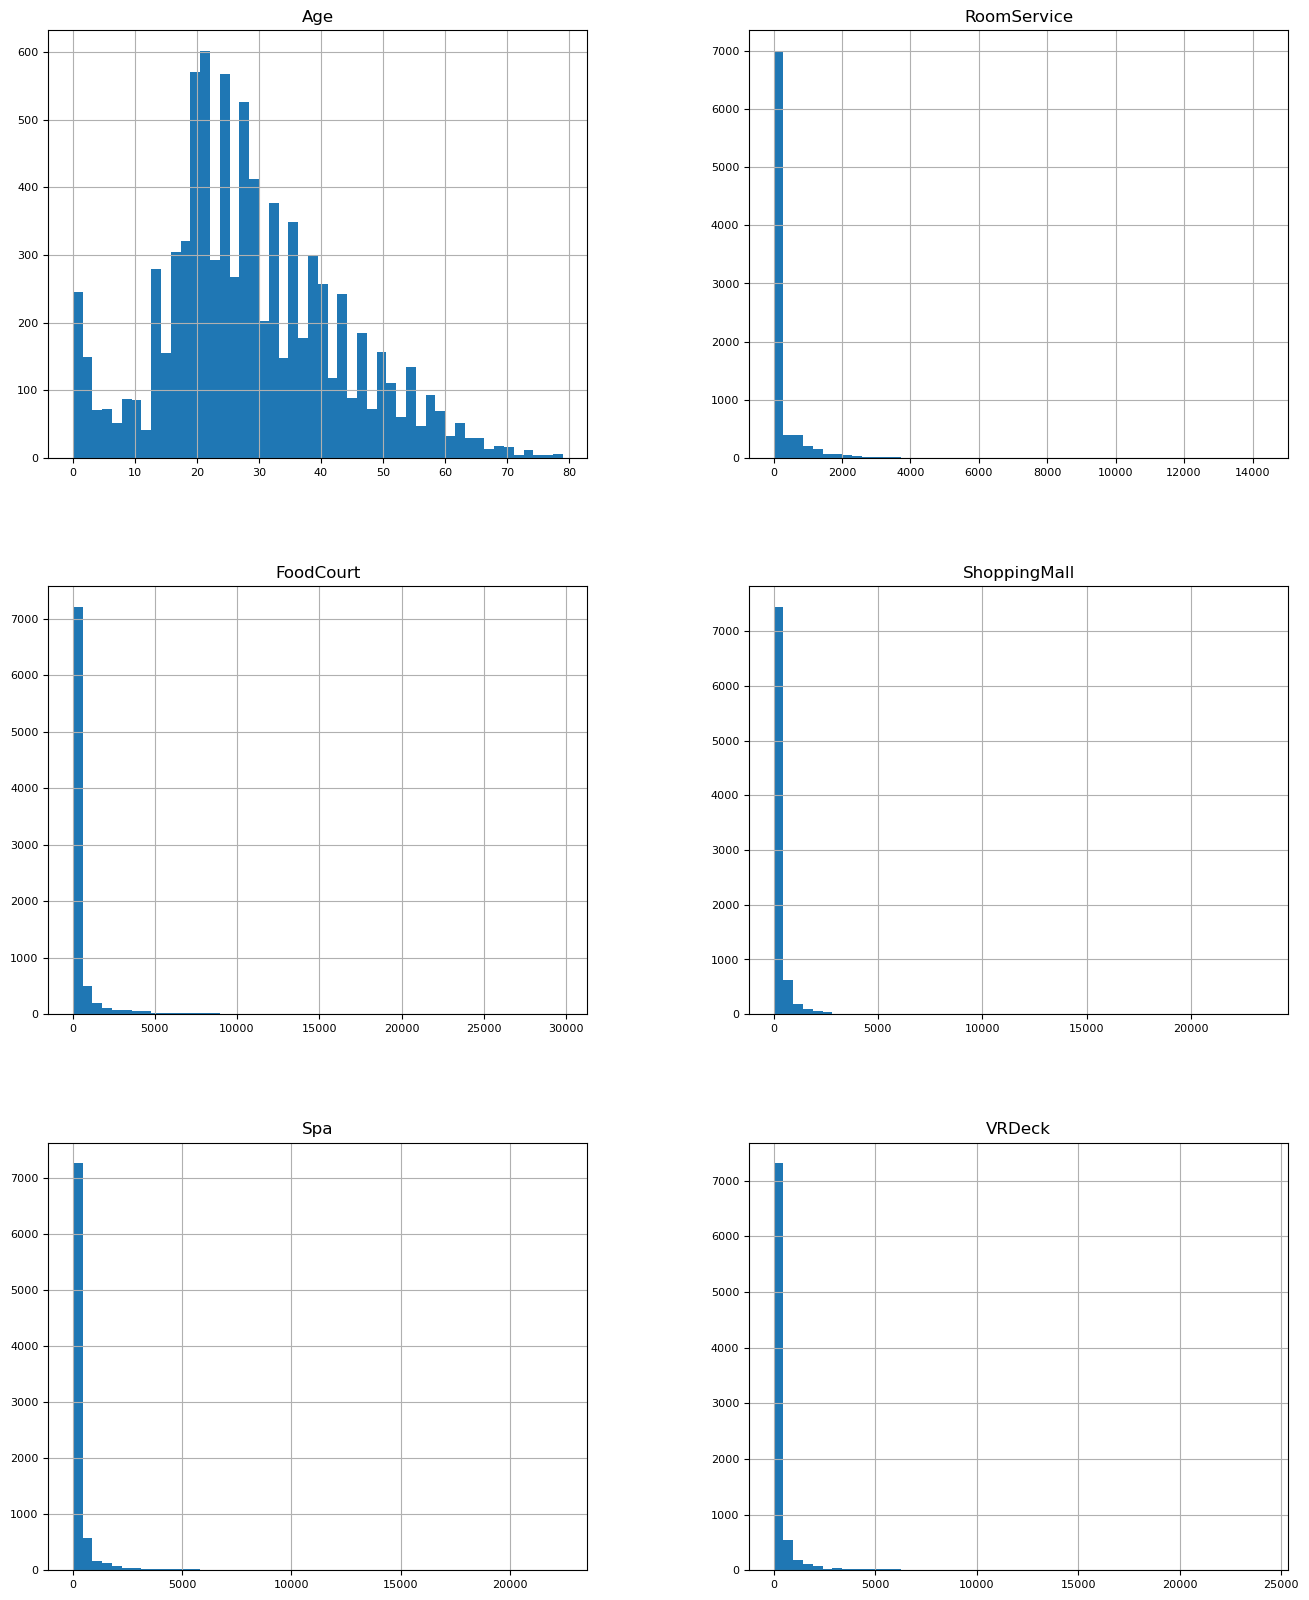

In [26]:
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [54]:
df['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [69]:
df = pd.read_csv('train.csv')
df['PassengerGroup'] = df['PassengerId'].astype(str).str[0:4]
df['Cabin'].fillna("None/None/None", inplace=True)
df[["deck", "deck_num", "side"]] = df["Cabin"].str.split("/", n=2, expand=True)

In [70]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,deck,deck_num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,E,608,S


In [71]:
# Identify categorical columns (object dtype OR pandas Categorical)
cat_cols = df.select_dtypes(include=["object", "category"]).columns

# If you also want to treat “numeric but really categorical” columns
# (e.g., MSSubClass) as categorical, just cast them first:
# df["MSSubClass"] = df["MSSubClass"].astype("category")

for col in cat_cols:
    print(f"\n=== {col} ===")
    print(df[col].value_counts(dropna=False))
#Looks like a pretty balanced dataset


=== PassengerId ===
PassengerId
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: count, Length: 8693, dtype: int64

=== HomePlanet ===
HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64

=== CryoSleep ===
CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

=== Cabin ===
Cabin
None/None/None    199
G/734/S             8
C/137/S             7
B/201/P             7
G/109/P             7
                 ... 
G/556/P             1
E/231/S             1
G/545/S             1
G/543/S             1
C/178/S             1
Name: count, Length: 6561, dtype: int64

=== Destination ===
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: count, dtype: int64

=== VIP ===
VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64

=== Name ===
Name
NaN             

In [72]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,deck,deck_num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,E,608,S


In [73]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'PassengerGroup', 'deck', 'deck_num', 'side'],
      dtype='object')

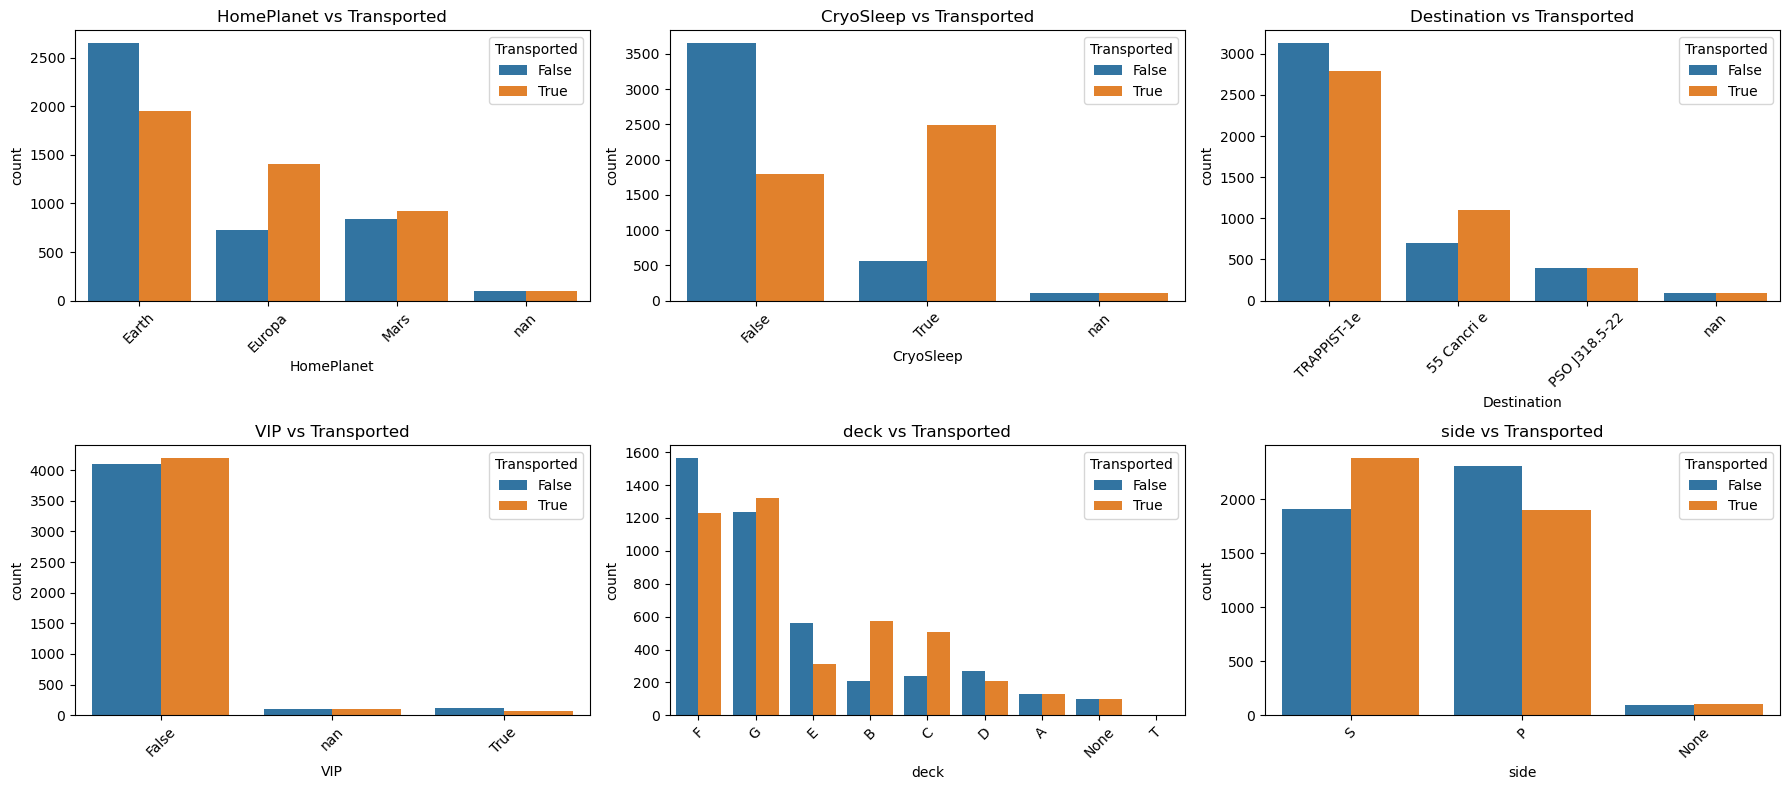

In [79]:

qualitative = [
    'HomePlanet', 'CryoSleep', 'Destination',
    'VIP',  'deck',  'side'
]

# 1️⃣  Cast every plot column—including Transported—to string (or 'category')
plot_cols = qualitative + ['Transported']
df[plot_cols] = df[plot_cols].astype(str)      # or .astype('category')

# 2️⃣  Draw the grouped bar charts
n_cols = 3
n_rows = (len(qualitative) + n_cols - 1) // n_cols
plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(qualitative, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(
        data=df,
        x=col,
        hue='Transported',
        order=df[col].value_counts().index
    )
    plt.title(f'{col} vs Transported')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Random Forest

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# ---------------- 1) load & drop columns ----------------
df = pd.read_csv("train.csv")
df['PassengerGroup'] = df['PassengerId'].astype(str).str[0:4]
df['Cabin'].fillna("None/None/None", inplace=True)
df[["deck", "deck_num", "side"]] = df["Cabin"].str.split("/", n=2, expand=True)
df = df.drop(columns=["PassengerId", "Cabin",'Name'])

y = df["Transported"].astype(int)
X = df.drop(columns=["Transported"])

# ---------------- 2) feature lists ----------------
categorical_cols = [
    'HomePlanet', 'CryoSleep', 'Destination', 'VIP',
    'PassengerGroup', 'deck', 'deck_num', 'side'
]

numeric_cols = [
    'Age', 'RoomService', 'FoodCourt',
    'ShoppingMall', 'Spa', 'VRDeck'
]

# ---------------- 3) preprocessing ----------------
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess = ColumnTransformer([
    ("cat", cat_pipe, categorical_cols),
    ("num", num_pipe, numeric_cols)
])

# ---------------- 4) model ----------------
rf = RandomForestClassifier(
    n_estimators=400,           # bump up for smoother estimates
    max_depth=None,            # tune if overfitting
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)

model = Pipeline([
    ("prep", preprocess),
    ("rf", rf)
])

# ---------------- 5) fit / evaluate ----------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model.fit(X_tr, y_tr)
print("Validation accuracy:", model.score(X_val, y_val))

cv_auc = cross_val_score(model, X, y, cv=5,
                         scoring="roc_auc", n_jobs=-1).mean()
print("5-fold ROC-AUC:", cv_auc)


Validation accuracy: 0.7906843013225991
5-fold ROC-AUC: 0.8653612993101175


In [92]:
test = pd.read_csv("test.csv")
ids = test["PassengerId"]
test['PassengerGroup'] = test['PassengerId'].astype(str).str[0:4]
test['Cabin'].fillna("None/None/None", inplace=True)
test[["deck", "deck_num", "side"]] = test["Cabin"].str.split("/", n=2, expand=True)
test = test.drop(columns=["PassengerId", "Cabin",'Name'])
pred = model.predict(test)
submission = pd.DataFrame({
    'PassengerId': ids,
    'Transported': pred
})

In [93]:
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv("submission.csv", index=False)